# 1st Test

In [44]:
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [45]:
# Garantir consistência para reproducibilidade
np.random.seed(42)

# Função para DWT e geração de lags
def dwt_transform(data, wavelet='db4', level=2):
    """Extrai componente de tendência usando DWT."""
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return coeffs[0]  # Tendência

def create_lags(data, n_lags=24):
    """Cria lags temporais para séries temporais."""
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])  # Janela de entrada
        y.append(data[i])           # Valor alvo
    return np.array(X), np.array(y)

In [46]:
df = pd.read_csv('../../dataset2001_2024.csv')
df.tail()

,YEAR,MO,DY,HR,ALLSKY_SFC_UV_INDEX,ALLSKY_SRF_ALB,CLRSKY_KT,CLOUD_AMT,T2M,PS,PW,WD10M,WD50M,WS50M,WS10M,TOA_SW_DNI,QV2M,QV10M
201595,2023,12,31,19,2.92,0.15,0.67,31.79,28.00,93.33,2.72,155.45,154.80,6.44,5.66,1408.66,11.47,11.29
201596,2023,12,31,20,0.80,0.13,0.58,20.45,25.87,93.38,2.70,152.49,152.07,7.36,6.12,1408.61,11.72,11.66
201597,2023,12,31,21,0.05,0.16,0.38,31.40,23.62,93.45,2.70,148.69,148.45,7.88,6.21,1408.76,12.08,12.02
201598,2023,12,31,22,0.00,-999.00,-999.00,21.06,21.87,93.52,2.71,145.60,145.61,7.41,5.61,0.00,12.45,12.39
201599,2023,12,31,23,0.00,-999.00,-999.00,22.94,20.82,93.55,2.72,140.66,140.22,6.68,4.93,0.00,12.70,12.70


In [47]:
# Filtrar dados apenas até 2022
df_filtered = df[df['YEAR'] < 2023]
t2m_data = df_filtered['T2M'].values

# Aplicar DWT para extrair tendência
trend_component = dwt_transform(t2m_data)

# Criar lags temporais com janela de 24 horas
n_lags = 24
X, y = create_lags(trend_component, n_lags=n_lags)

# Escalar os dados
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Ajustar a entrada para o formato (samples, timesteps, features)
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

In [48]:
# Separar treino e teste (80% treino)
train_size = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

In [52]:
# Criar o modelo LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_lags, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=True), 
    Dropout(0.2),
    LSTM(16),  
    Dropout(0.2),
    Dense(64, activation='relu'), 
    Dense(1)  
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early Stopping para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinar o modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    #callbacks=[early_stop]
)

# Fazer previsões
predictions_scaled = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions_scaled)

# Converter os valores reais para a escala original
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/100


c:\Users\Natan Guedes\Documents\Dev\PFC\pfc\py9\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0234 - mae: 0.1172 - val_loss: 0.0140 - val_mae: 0.0942
Epoch 2/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0091 - mae: 0.0753 - val_loss: 0.0070 - val_mae: 0.0652
Epoch 3/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0053 - mae: 0.0559 - val_loss: 0.0068 - val_mae: 0.0662
Epoch 4/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0042 - mae: 0.0493 - val_loss: 0.0049 - val_mae: 0.0529
Epoch 5/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0037 - mae: 0.0463 - val_loss: 0.0040 - val_mae: 0.0474
Epoch 6/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0033 - mae: 0.0438 - val_loss: 0.0064 - val_mae: 0.0604
Epoch 7/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0030 - mae: 0.0414 - val_loss: 0.0042 - val_mae: 0.0493
Epoch 8/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0020 - mae: 0.0341 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 9/100
1205/1205 ━━━━━━━━━━━━━━

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Preparação dos dados (X e y já preparados anteriormente com os lags)
# Garantir que os dados ainda estão disponíveis
X_rf_train, X_rf_test = X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)
y_rf_train, y_rf_test = y_train, y_test

# Treinamento do Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_rf_train, y_rf_train.ravel())

# Previsões
rf_predictions_scaled = rf_model.predict(X_rf_test)
rf_predictions = scaler_y.inverse_transform(rf_predictions_scaled.reshape(-1, 1))
y_rf_test_real = scaler_y.inverse_transform(y_rf_test.reshape(-1, 1))

# Avaliação do modelo
mae_rf = mean_absolute_error(y_rf_test_real, rf_predictions)
rmse_rf = np.sqrt(mean_squared_error(y_rf_test_real, rf_predictions))

print(f"Random Forest - MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}")


Random Forest - MAE: 1.6359, RMSE: 2.3378


## Comparison between RF and LSTM

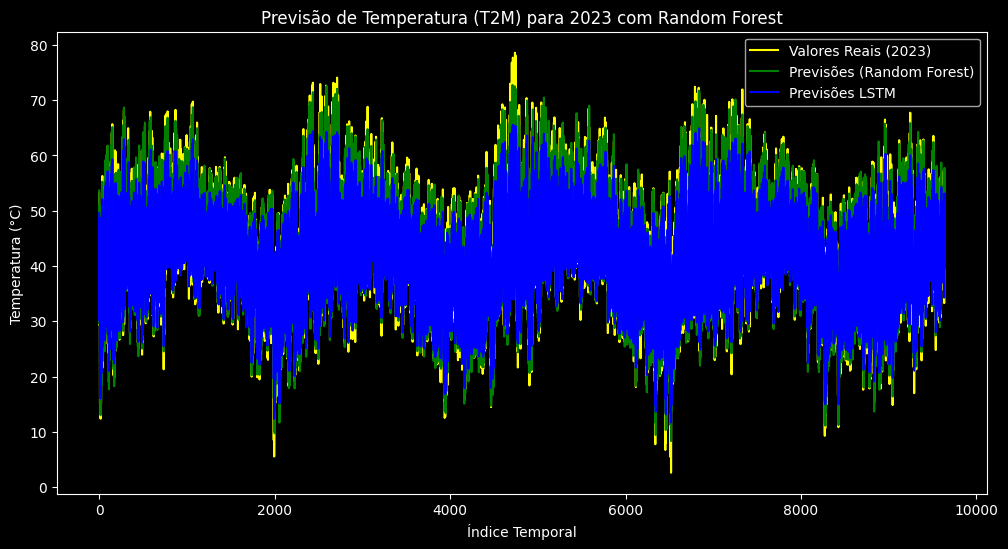

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(y_rf_test_real, label='Valores Reais (2023)', color='yellow')
plt.plot(rf_predictions, label='Previsões (Random Forest)', color='green')
plt.plot(predictions, label='Previsões LSTM', color='blue')
plt.title('Previsão de Temperatura (T2M) para 2023 com Random Forest')
plt.xlabel('Índice Temporal')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()

In [56]:
mae_lstm = mean_absolute_error(y_test_real, predictions)
rmse_lstm = np.sqrt(mean_squared_error(y_test_real, predictions))
mae_rf = mean_absolute_error(y_test_real, rf_predictions)
rmse_rf = np.sqrt(mean_squared_error(y_test_real, rf_predictions))

print(f"LSTM - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")
print(f"Random Forest - MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}")

LSTM - MAE: 2.2481, RMSE: 2.9842
Random Forest - MAE: 1.6359, RMSE: 2.3378


# 2nd - Improving LSTM and RF

Epoch 1/100


c:\Users\Natan Guedes\Documents\Dev\PFC\pfc\py9\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.0208 - val_loss: 0.0154
Epoch 2/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0114 - val_loss: 0.0084
Epoch 3/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0062 - val_loss: 0.0052
Epoch 4/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0045 - val_loss: 0.0065
Epoch 5/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 6/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 7/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 8/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 11/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 12/100
603/603 ━━━━━━━━━━━━

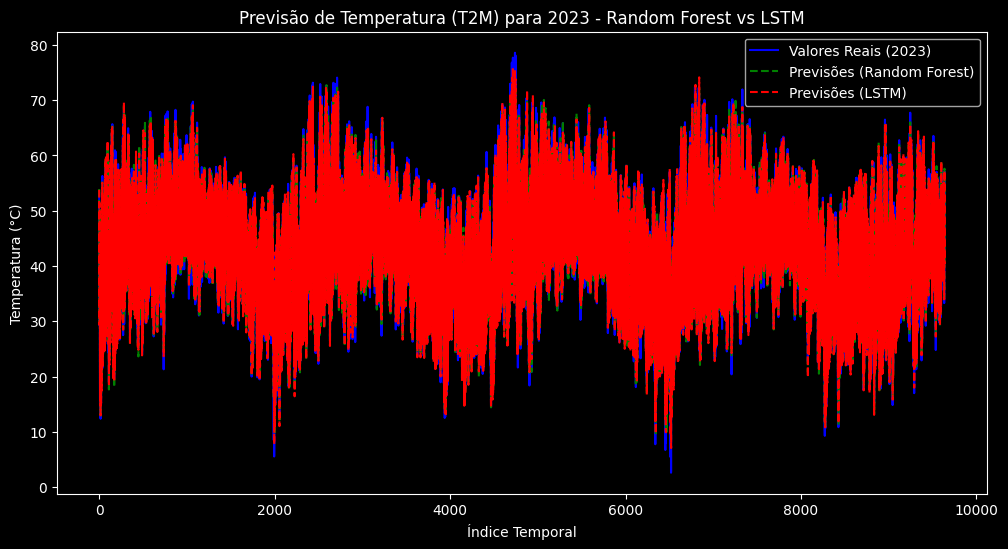

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Certifique-se de que os dados X_train, X_test, y_train, y_test já estão preparados.
# Normalização assumida como anteriormente configurada.

# Reconstruir o modelo LSTM com melhorias
model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compilação com otimizador ajustado
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Treinamento com Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_lstm = model_lstm.fit(X_train, y_train, epochs=100, batch_size=64, 
                               validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Previsões do modelo LSTM
lstm_predictions_scaled = model_lstm.predict(X_test)
lstm_predictions = scaler_y.inverse_transform(lstm_predictions_scaled.reshape(-1, 1))

# Invertendo a escala dos valores reais
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Treinamento do Random Forest com parâmetros ajustados
rf_model = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())

# Previsões do Random Forest
rf_predictions_scaled = rf_model.predict(X_test.reshape(X_test.shape[0], -1))
rf_predictions = scaler_y.inverse_transform(rf_predictions_scaled.reshape(-1, 1))

# Cálculo das métricas
mae_lstm = mean_absolute_error(y_test_real, lstm_predictions)
rmse_lstm = np.sqrt(mean_squared_error(y_test_real, lstm_predictions))
mae_rf = mean_absolute_error(y_test_real, rf_predictions)
rmse_rf = np.sqrt(mean_squared_error(y_test_real, rf_predictions))

print(f"LSTM - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")
print(f"Random Forest - MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}")

# Plot comparativo
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Valores Reais (2023)', color='blue')
plt.plot(rf_predictions, label='Previsões (Random Forest)', color='green', linestyle='dashed')
plt.plot(lstm_predictions, label='Previsões (LSTM)', color='red', linestyle='dashed')
plt.title('Previsão de Temperatura (T2M) para 2023 - Random Forest vs LSTM')
plt.xlabel('Índice Temporal')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()


# 3rd - Using Autoencoder to perform SSL

In [59]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed

# Parâmetros da série temporal
timesteps = X_train.shape[1]
features = X_train.shape[2]

# Definição do autoencoder
input_seq = Input(shape=(timesteps, features))

# Encoder
encoded = LSTM(64, activation='relu', return_sequences=False)(input_seq)
encoded_output = RepeatVector(timesteps)(encoded)

# Decoder
decoded = LSTM(64, activation='relu', return_sequences=True)(encoded_output)
decoded_output = TimeDistributed(Dense(features))(decoded)

# Construção do modelo autoencoder
autoencoder = Model(inputs=input_seq, outputs=decoded_output)
autoencoder.compile(optimizer='adam', loss='mse')

# Treinamento Self-Supervised
autoencoder.fit(X_train, X_train, epochs=20, batch_size=32, validation_data=(X_test, X_test))


Epoch 1/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0260 - val_loss: 0.0130
Epoch 2/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 3/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0060 - val_loss: 0.0028
Epoch 4/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 5/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 7/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 8.1997e-04 - val_loss: 7.5586e-04
Epoch 8/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 6.7316e-04 - val_loss: 7.3686e-04
Epoch 9/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 6.4110e-04 - val_loss: 6.6250e-04
Epoch 10/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 5.9465e-04 - val_loss: 6.7583e-04
Epoch 11/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 5.7027e-04 - val_loss: 

In [60]:
# Extraindo o encoder do autoencoder
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)

# Construindo o modelo supervisionado com os pesos treinados
from tensorflow.keras.models import Sequential

model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

# Transferir pesos do encoder para a primeira camada LSTM do novo modelo
model_lstm.layers[0].set_weights(encoder_model.get_weights())
model_lstm.layers[0].trainable = False  # Congelando os pesos

# Compilar e treinar o modelo supervisionado
model_lstm.compile(optimizer='adam', loss='mse')

# Treinamento supervisionado
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50


c:\Users\Natan Guedes\Documents\Dev\PFC\pfc\py9\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0313 - val_loss: 0.0186
Epoch 2/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0147 - val_loss: 0.0170
Epoch 3/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0142 - val_loss: 0.0157
Epoch 4/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0137 - val_loss: 0.0161
Epoch 5/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0130 - val_loss: 0.0144
Epoch 6/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0126 - val_loss: 0.0138
Epoch 7/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0119 - val_loss: 0.0130
Epoch 8/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0112 - val_loss: 0.0121
Epoch 9/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0107 - val_loss: 0.0116
Epoch 10/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0103 - val_loss: 0.0120
Epoch 11/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0101 - val_loss: 0.0113
Epoch 12/50
1205/1205 ━━━━━━━━━━━━━━━━━━━

Epoch 1/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0218
Epoch 2/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0014
Epoch 3/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 4/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.8133e-04
Epoch 5/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.8888e-04
Epoch 6/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.6261e-04
Epoch 7/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.4856e-04
Epoch 8/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.2220e-04
Epoch 9/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.9813e-04
Epoch 10/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.8124e-04
Epoch 11/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.5902e-04
Epoch 12/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.5824e-04
Epoch 13/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.6364e-04
Epoch 14/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - lo

c:\Users\Natan Guedes\Documents\Dev\PFC\pfc\py9\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - loss: 0.0106 - val_loss: 6.6610e-04
Epoch 2/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step - loss: 6.0112e-04 - val_loss: 6.9439e-04
Epoch 3/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step - loss: 5.8158e-04 - val_loss: 6.8409e-04
Epoch 4/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step - loss: 5.9241e-04 - val_loss: 7.2738e-04
Epoch 5/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - loss: 6.1466e-04 - val_loss: 6.6148e-04
Epoch 6/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - loss: 6.0491e-04 - val_loss: 7.0509e-04
Epoch 7/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - loss: 6.0190e-04 - val_loss: 6.9371e-04
Epoch 8/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 596us/step - loss: 5.9741e-04 - val_loss: 6.5816e-04
Epoch 9/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - loss: 6.1958e-04 - val_loss: 6.6519e-04
Epoch 10/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step - loss: 5.8989e-04 - val_loss: 6.5999e-04
Epoch 11/50
1205/1205 ━━━━━━━━━━━━

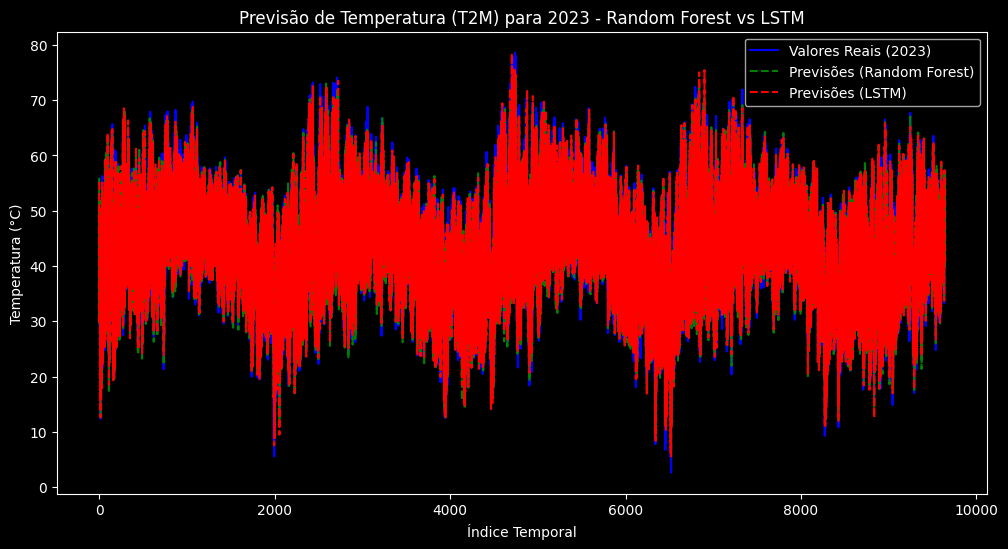

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# Certifique-se de que os dados X_train, X_test, y_train, y_test já estão preparados.
# Normalização assumida como anteriormente configurada.

# Verificação de dimensões compatíveis
assert X_train.shape[0] == y_train.shape[0], "Tamanhos incompatíveis entre X_train e y_train"
assert X_test.shape[0] == y_test.shape[0], "Tamanhos incompatíveis entre X_test e y_test"

# Autoencoder com LSTM para Self-Supervised Learning
encoding_dim = 32

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
encoded = LSTM(64, return_sequences=False)(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(X_train.shape[2], activation='linear')(encoded)

# Construção do autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

# Compilação do autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Treinamento do autoencoder
early_stopping_ae = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
autoencoder.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stopping_ae], verbose=1)

# Codificação dos dados de treino e teste
X_encoded_train = encoder.predict(X_train)
X_encoded_test = encoder.predict(X_test)

# Reconstrução do modelo LSTM supervisionado com pesos do encoder
model_lstm = Sequential([
    Dense(64, activation='relu', input_shape=(encoding_dim,)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compilação
model_lstm.compile(optimizer='adam', loss='mse')

# Treinamento com Early Stopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history_lstm = model_lstm.fit(X_encoded_train, y_train, epochs=50, batch_size=32, 
                               validation_data=(X_encoded_test, y_test), callbacks=[early_stopping], verbose=1)

# Previsões do modelo LSTM
lstm_predictions_scaled = model_lstm.predict(X_encoded_test)
lstm_predictions = scaler_y.inverse_transform(lstm_predictions_scaled.reshape(-1, 1))

# Invertendo a escala dos valores reais
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Treinamento do Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_encoded_train, y_train.ravel())

# Previsões do Random Forest
rf_predictions_scaled = rf_model.predict(X_encoded_test)
rf_predictions = scaler_y.inverse_transform(rf_predictions_scaled.reshape(-1, 1))

# Cálculo das métricas
mae_lstm = mean_absolute_error(y_test_real, lstm_predictions)
rmse_lstm = np.sqrt(mean_squared_error(y_test_real, lstm_predictions))
mae_rf = mean_absolute_error(y_test_real, rf_predictions)
rmse_rf = np.sqrt(mean_squared_error(y_test_real, rf_predictions))

print(f"LSTM - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")
print(f"Random Forest - MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}")

# Plot comparativo
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Valores Reais (2023)', color='blue')
plt.plot(rf_predictions, label='Previsões (Random Forest)', color='green', linestyle='dashed')
plt.plot(lstm_predictions, label='Previsões (LSTM)', color='red', linestyle='dashed')
plt.title('Previsão de Temperatura (T2M) para 2023 - Random Forest vs LSTM com SSL')
plt.xlabel('Índice Temporal')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()

